In [ ]:
#!pip -q install FireHR==0.1.2 pyhdf==0.10.2
#!pip install rasterio
#!pip install geopandas
#!pip install elevation
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
#!cp "/content/gdrive/MyDrive/FYP_dataset.csv" "/content"
!cp "/content/gdrive/MyDrive/FYP_dataset_without_nulls_with_labels for 6 clusters.csv" "/content"
#!unzip '/content/gdrive/MyDrive/satdata(1-13500).zip' -d '/content/data'
#!unzip '/content/gdrive/MyDrive/satdata(13501-29556).zip' -d '/content/data'

Mounted at /content/gdrive


In [ ]:


from time import time
import keras.backend as K
#from keras.engine.topology import Layer, InputSpec
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
#import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataset = pd.read_csv("/content/FYP_dataset_without_nulls_with_labels for 6 clusters.csv")
dataset = dataset.dropna()
X = dataset[['mean_ndwi', 'mean_ui', 'mean_laterite', 'mean_biotite', 'mean_gossan']]
X

,mean_ndwi,mean_ui,mean_laterite,mean_biotite,mean_gossan
0,0.648128,-0.684599,1.155860,0.868981,0.249872
1,0.759351,-0.785770,1.160259,0.869430,0.154899
2,0.720186,-0.745760,1.138680,0.883345,0.189888
3,-0.032273,-0.051760,1.188390,0.844293,1.391104
4,0.390859,-0.441434,1.158592,0.864900,0.615722
...,...,...,...,...,...
6514,0.144614,-0.320295,1.469534,0.687069,0.759191
6515,0.066850,-0.229285,1.405355,0.715740,0.862835
6516,0.067720,-0.213589,1.362413,0.741399,0.823023
6517,0.093175,-0.232800,1.342354,0.746773,0.799523


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
X.shape

(6519, 5)

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

distortions = []

for K in range(1, 25):
  kmeans = KMeans(n_clusters = K, n_init=15, max_iter=500)
  kmeans.fit_predict(X)
  #score = silhouette_score (X, preds)
  #print ("For n_clusters = {}, Kmeans silhouette score is {})".format(K, score))
  distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
  

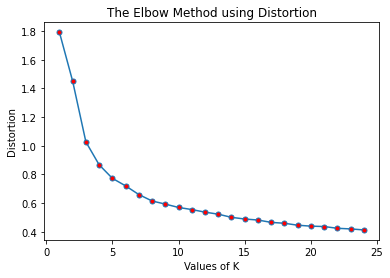

In [ ]:
plt.plot(range(1, 25), distortions, marker = 'o', markerfacecolor='red', markersize = 5)
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score


kmeans = KMeans(n_clusters = 6, n_init=15, max_iter=500)
y_pred_kmeans = kmeans.fit_predict(X)
kmeans.cluster_centers_

array([[-0.36112603,  0.30692421,  0.0586536 , -0.17379346,  0.19232775],
       [ 1.65230565, -1.50212352, -0.210297  ,  0.19883082, -1.60632848],
       [ 0.17348146, -0.43908862,  1.06953806, -1.11794419,  0.33663189],
       [-0.55202918,  0.74388735, -0.87166272,  0.93997476,  0.03970367],
       [ 3.61815686, -3.20930425, -0.75767435,  0.87286914, -3.22882203],
       [ 0.68053635, -1.22766558,  2.80604057, -2.38818211,  1.92810949]])

In [ ]:
n_clusters = 6 
n_epochs   = 100
batch_size = 64

In [ ]:
def autoencoder(dims, act="relu", init="glorot_uniform"):
  n_stacks=len(dims)-1
  input_data = Input(shape=(dims[0],), name="input")
  x = input_data
  for i in range(n_stacks-1):
    x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)
  encoded = Dense(dims[-1],kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)
  x = encoded

  for i in range(n_stacks-1, 0, -1):
    x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

  x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
  decoded = x

  autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
  encoder_model     = Model(inputs=input_data, outputs=encoded, name='encoder')

  return autoencoder_model, encoder_model



In [ ]:


dims=[X.shape[-1],500,500,2000,5]
init = VarianceScaling(scale=1. / 3. , mode="fan_in", distribution="uniform")

pretrain_optimizer = SGD(learning_rate=1, momentum=0.9)
n_clusters=6
pretrain_epochs = 100
batch_size = 64
save_dir = './results'

In [ ]:
dims

[5, 500, 500, 2000, 5]

In [ ]:
autoencoder, encoder = autoencoder(dims, init=init)

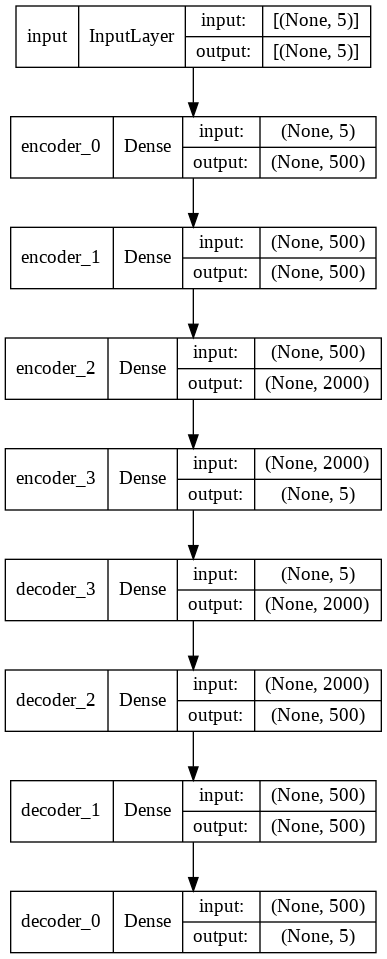

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')

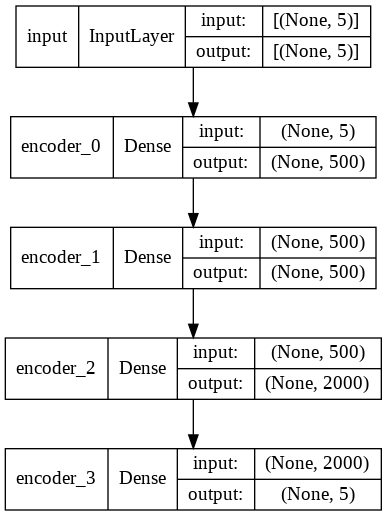

In [ ]:
plot_model(encoder, to_file='encoder.png', show_shapes=True)

Image(filename='encoder.png')

In [ ]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(X, X, batch_size=batch_size, epochs=pretrain_epochs)


Epoch 1/100
102/102 [==============================] - 5s 42ms/step - loss: 0.0185
Epoch 2/100
102/102 [==============================] - 4s 40ms/step - loss: 0.0023
Epoch 3/100
102/102 [==============================] - 4s 41ms/step - loss: 5.0259e-04
Epoch 4/100
102/102 [==============================] - 4s 40ms/step - loss: 4.0626e-04
Epoch 5/100
102/102 [==============================] - 4s 39ms/step - loss: 3.7460e-04
Epoch 6/100
102/102 [==============================] - 4s 40ms/step - loss: 3.6305e-04
Epoch 7/100
102/102 [==============================] - 4s 44ms/step - loss: 3.3422e-04
Epoch 8/100
102/102 [==============================] - 5s 45ms/step - loss: 3.2698e-04
Epoch 9/100
102/102 [==============================] - 4s 41ms/step - loss: 3.2683e-04
Epoch 10/100
102/102 [==============================] - 4s 41ms/step - loss: 2.5259e-04
Epoch 11/100
102/102 [==============================] - 5s 44ms/step - loss: 1.0137e-04
Epoch 12/100
102/102 [===========================

In [ ]:
autoencoder.save_weights(save_dir + '/ae_weights.h5')

In [ ]:

autoencoder.load_weights(save_dir + '/ae_weights.h5')


In [ ]:
class ClusteringLayer(Layer):
  def __init__(self, n_clusters, weights, alpha=1.0,**kwargs):
    if 'input_shape' not in kwargs and 'input_dim' in kwargs:
      kwargs['input_shape']=(kwargs.pop('input_dim'),)
    super(ClusteringLayer,self).__init__(**kwargs)
    self.n_clusters=n_clusters
    
    self.alpha=alpha
    self.initial_weights = weights
    self.input_spec = InputSpec(ndim=2)
    

    def build(self, input_shape):
        #assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
        
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True
    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q


    def compute_output_shape(self, input_shape):
        #assert input_shape and len(input_shape) == 2
        print(self.n_clusters)
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
clustering_layer = ClusteringLayer(n_clusters=6,weights=None, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

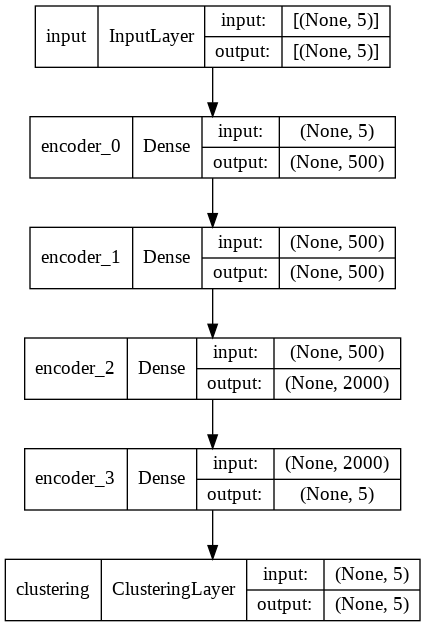

In [ ]:

plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 

In [ ]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

In [ ]:
#from scipy.spatial.distance import cdist
X_enc=encoder.predict(X)
distortions=[]
for K in range(1, 25):
  kmeans = KMeans(n_clusters = K, n_init=15, max_iter=500)
  
  kmeans.fit_predict(X_enc)
  distortions.append(sum(np.min(cdist(X_enc, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / X_enc.shape[0])

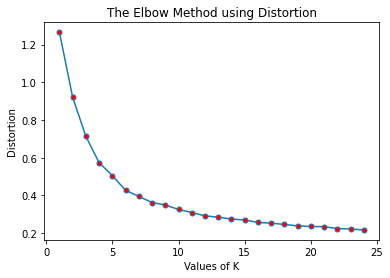

In [ ]:
plt.plot(range(1, 25), distortions, marker = 'o', markerfacecolor='red', markersize = 5)
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(X))

In [ ]:
y_pred_last = np.copy(y_pred)

In [ ]:
kmeans.cluster_centers_

array([[ 0.00317316, -0.30415267, -0.1777964 ,  0.38621426, -0.43852225],
       [-0.02114041, -0.14337474, -0.11693053,  0.3854406 ,  0.3417434 ],
       [-0.13053617,  0.38634634, -0.61679006,  1.1088003 , -0.18525997],
       [ 0.03306343, -0.0995801 , -0.11389778,  0.3035948 ,  0.1207269 ],
       [-0.05628329,  0.13926391, -0.38172114,  0.72757876, -0.0371063 ],
       [ 0.04492199, -0.10764636, -0.15156938,  0.31510878, -0.11391375]],
      dtype=float32)

In [ ]:
#model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
clustering_layer = ClusteringLayer(n_clusters=6, weights=[kmeans.cluster_centers_], name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

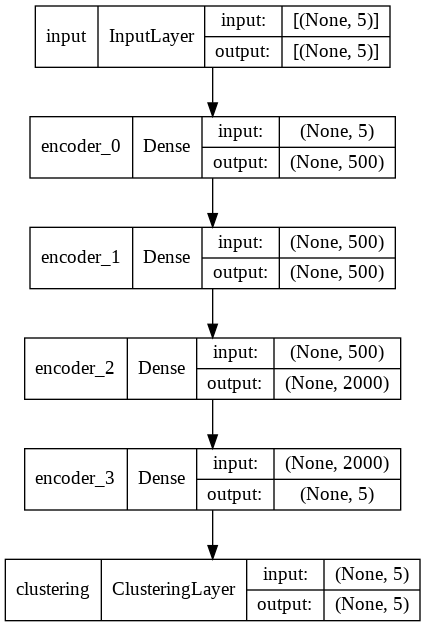

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 